# We are assembling all elements of figure 1 of the TwinC paper in this notebook. 

In [1]:
import sys
sys.path.append("../../twinc")

import os
import gzip
import torch
import cooler
import pyBigWig
import argparse
import matplotlib
import numpy as np
import seaborn as sns
import _pickle as pickle
from scipy.stats import gmean
import matplotlib.pyplot as plt
from twinc_data import TransContacts
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, roc_auc_score

if not os.path.exists(f"../../figures"):
    os.system(f"mkdir ../../figures")
else:
    print(f"figures directory exists")

if not os.path.exists(f"../../figures/classification_accuracy"):
    os.system(f"mkdir ../../figures/classification_accuracy")
else:
    print(f"classification_accuracy figures directory exists")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


figures directory exists
classification_accuracy figures directory exists


# Heart left ventricle

## 1. Visualize observed and predicted Hi-C data (heart left ventricle)

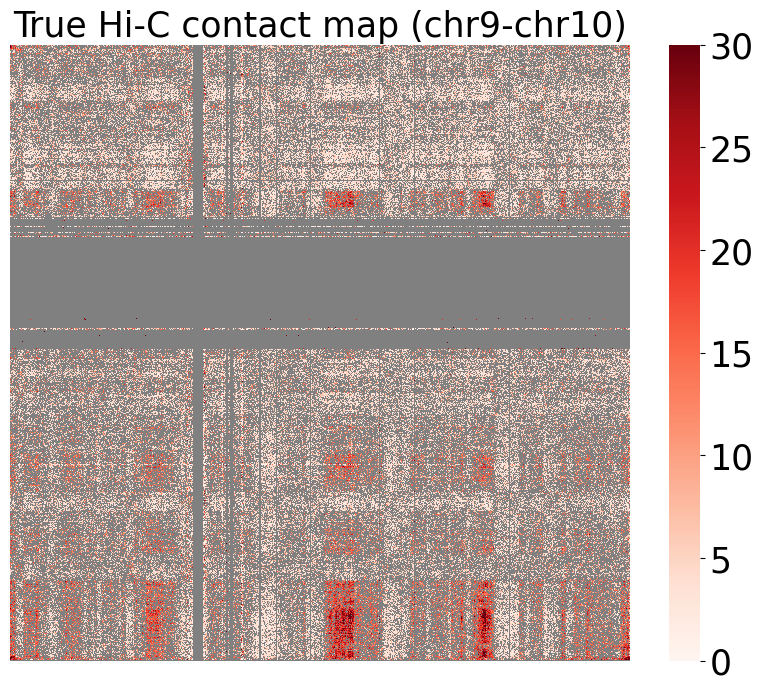

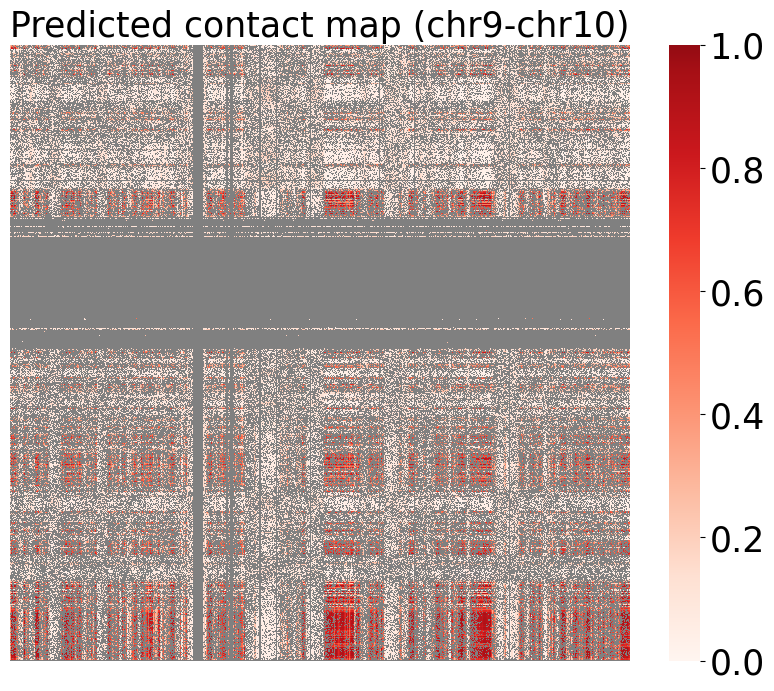

In [2]:
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]

test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_left//chr9_chr10_test_results.npz")

hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
pred_matrix = test_results_pos_pos["pred_matrix_pos"]
pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

true_matrix = np.zeros((hic_pos_num_sup.shape))
true_matrix[:, :] = np.nan

true_matrix[hic_pos_num_sup==1] = 1
true_matrix[hic_neg_num_sup==1] = 0

plt.rcParams['axes.facecolor']='gray'
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
hic_sum_noartifacts[np.isnan(true_matrix)] = np.nan
ax_0= sns.heatmap(hic_sum_noartifacts, cbar=True, cmap="Reds", vmax=30, xticklabels=False, yticklabels=False, ax=axis)
ax_0.set_title("True Hi-C contact map (chr9-chr10)")
plt.savefig(f"../../figures/classification_accuracy/chr9_chr10_observed_visualize_hlv.png")
plt.show()

# modify color scale
# set how many colors you want in color map
cmap_reds = plt.cm.get_cmap('Reds', len(pred_matrix)+10000) 
alpha = 1
colors = []
for ind in range(cmap_reds.N):
    c = []
    for x in cmap_reds(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
my_reds_cmap=ListedColormap(colors[0:-1000], name = 'my_reds')

figure, axis = plt.subplots(1, 1, figsize=(10, 8))
pred_matrix[np.isnan(true_matrix)] = np.nan
ax_1 = sns.heatmap(pred_matrix, cbar=True, cmap=my_reds_cmap, vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=axis)
ax_1.set_title("Predicted contact map (chr9-chr10)")
plt.savefig(f"../../figures/classification_accuracy/chr9_chr10_predict_visualize_hlv.png")
plt.show()

## 2. ROC Curve heart left ventricle

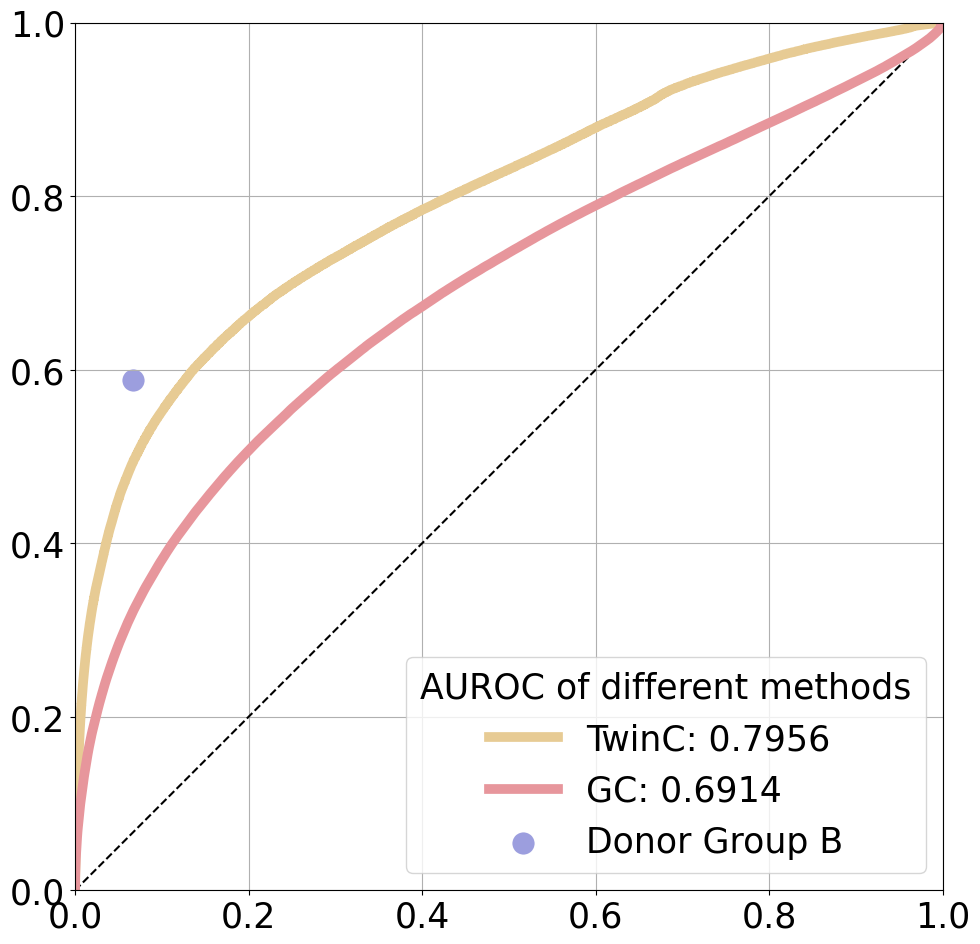

In [3]:
chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
all_true = []
all_pred = []
all_rep = []
all_pred_gc = []
for chrA, chrB in chr_combs: 
    binary_replicate = f"../../results/common_matrix_5_v_5_left/{chrA}_{chrB}_heart_left_ventricle_100000_5_v_5_replicate.gz"

    binary_replicate_contacts = pickle.load(gzip.open(binary_replicate, 'rb'))

    rep_labels = np.zeros((binary_replicate_contacts.hic_pos_num_sup.shape))
    rep_labels[:, :] = binary_replicate_contacts.hic_pos_num_sup
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==1] = 1
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==1] = 0

    hic_values_rep = binary_replicate_contacts.hic_sum
    test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_left//{chrA}_{chrB}_test_results.npz")

    hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
    hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
    hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

    true_matrix = np.zeros((hic_pos_num_sup.shape))
    true_matrix[:, :] = np.nan

    true_matrix[hic_pos_num_sup==1] = 1
    true_matrix[hic_neg_num_sup==1] = 0

    valid = np.isfinite(true_matrix) * np.isfinite(rep_labels)

    all_true.extend(true_matrix[valid].flatten())
    all_pred.extend(pred_matrix[valid].flatten())
    all_rep.extend(rep_labels[valid].flatten())
    all_pred_gc.extend(pred_matrix_gc[valid].flatten())

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]
figure, axis = plt.subplots(1, 1, figsize=(17, 10))
axis.plot([0, 1.0], [0, 1.0], "k--")

axis.grid(True)
fpr, tpr, thresholds = roc_curve(all_true, all_pred, pos_label=1)
twincnn_auroc = roc_auc_score(all_true, all_pred)
axis.plot(fpr, tpr, linewidth=7.0, label=f"TwinC: {twincnn_auroc:0.4f}", color=colors[1])

fpr, tpr, thresholds = roc_curve(all_true, all_pred_gc, pos_label=1)
gc_auroc = roc_auc_score(all_true, all_pred_gc)
axis.plot(fpr, tpr, linewidth=7.0, label=f"GC: {gc_auroc:0.4f}", color=colors[2])
    
fpr, tpr, thresholds = roc_curve(all_true, all_rep, pos_label=1)
donor_auroc = roc_auc_score(all_true, all_rep)
axis.scatter(fpr[1], tpr[1], linewidth=10.0, label=f"Donor Group B", color=colors[0])

axis.set_aspect('equal', adjustable='box')
axis.set_xlim([0, 1.0])
axis.set_ylim([0, 1.0])
plt.legend(title="AUROC of different methods", loc='lower right')
plt.tight_layout()
plt.savefig(f"../../figures/classification_accuracy/test_roc_hlv.pdf", transparent=True) 
plt.show()

## 3. Predictive accuracy by chromosome length

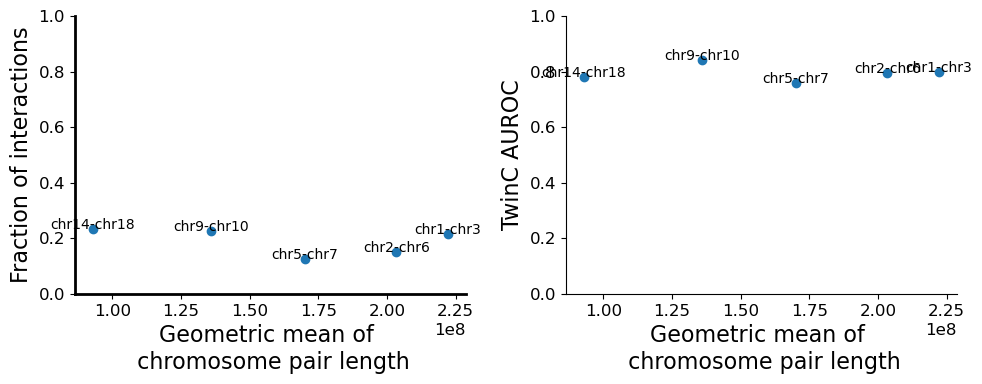

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]

chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
chr_comb_gmeans = [gmean([248956422, 198295559]), 
                    gmean([242193529, 170805979]), 
                    gmean([181538259, 159345973]), 
                    gmean([138394717, 133797422]), 
                    gmean([107043718, 80373285])]
all_auroc = []
all_chrpairs = []
pos_all = []
neg_all = []
for i in range(len(chr_combs)):
    chrA, chrB = chr_combs[i]
    binary_replicate = f"../../results/common_matrix_5_v_5_left/{chrA}_{chrB}_heart_left_ventricle_100000_5_v_5_replicate.gz"

    binary_replicate_contacts = pickle.load(gzip.open(binary_replicate, 'rb'))

    rep_labels = np.zeros((binary_replicate_contacts.hic_pos_num_sup.shape))
    rep_labels[:, :] = binary_replicate_contacts.hic_pos_num_sup
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==1] = 1
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==1] = 0

    hic_values_rep = binary_replicate_contacts.hic_sum
    test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_left//{chrA}_{chrB}_test_results.npz")

    hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
    hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
    hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

    true_matrix = np.zeros((hic_pos_num_sup.shape))
    true_matrix[:, :] = np.nan

    true_matrix[hic_pos_num_sup==1] = 1
    true_matrix[hic_neg_num_sup==1] = 0

    valid = np.isfinite(true_matrix) * np.isfinite(rep_labels)

    all_true = true_matrix[valid].flatten()
    all_pred = pred_matrix[valid].flatten()
    
    pos_all.append(np.sum(all_true==1)/float(len(all_true)))
    neg_all.append(np.sum(all_true==0)/float(len(all_true)))
    
    twincnn_auroc = roc_auc_score(all_true, all_pred)
    all_auroc.append(twincnn_auroc)
    all_chrpairs.append(f"{chrA}-{chrB}")

figure, axis = plt.subplots(1, 2, figsize=(10, 4))

for ax in ['top','bottom','left','right']:
    axis[0].spines[ax].set_linewidth(2)

axis[0].scatter(chr_comb_gmeans, pos_all)
for i in range(len(chr_comb_gmeans)):
    axis[0].text(chr_comb_gmeans[i], pos_all[i], f'{all_chrpairs[i]}', fontsize=10, ha='center')
axis[0].set_ylim([0, 1])
axis[0].set_xlabel("Geometric mean of \n chromosome pair length")
axis[0].set_ylabel("Fraction of interactions")
axis[0].spines[['right', 'top']].set_visible(False)

axis[1].scatter(chr_comb_gmeans, all_auroc)
for i in range(len(chr_comb_gmeans)):
    axis[1].text(chr_comb_gmeans[i], all_auroc[i], f'{all_chrpairs[i]}', fontsize=10, ha='center')
axis[1].set_ylim([0, 1])
axis[1].set_xlabel("Geometric mean of \n chromosome pair length")
axis[1].set_ylabel("TwinC AUROC")
axis[1].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig("../../figures/classification_accuracy/hlv_per_chrom_accuracy.pdf", transparent=True)
plt.show()

# Heart Right Ventricle

## 1. Visualize observed and predicted Hi-C data (heart right ventricle)

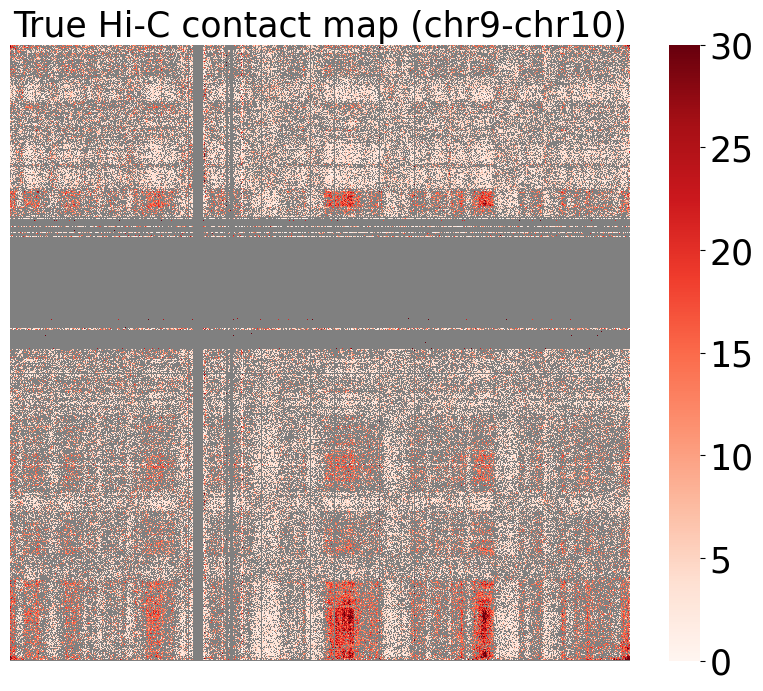

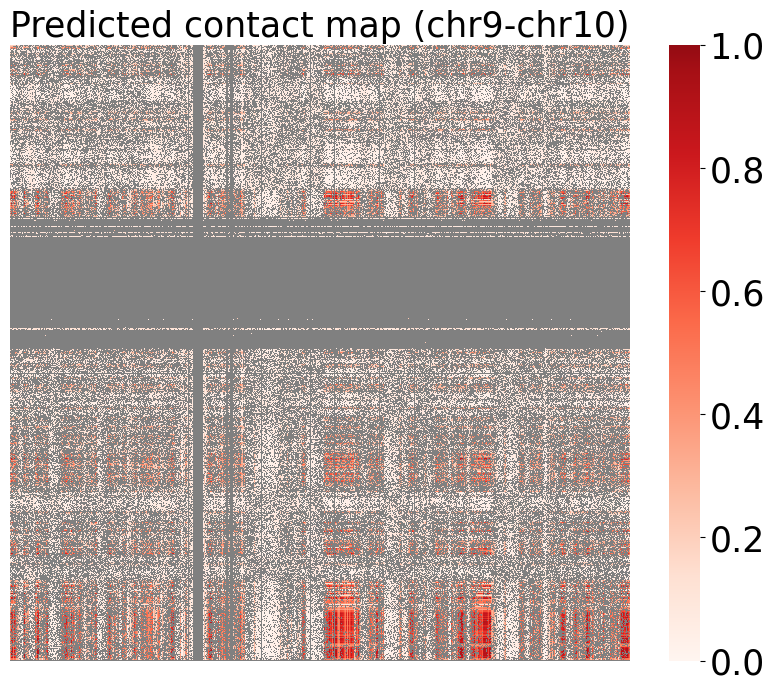

In [5]:
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]

test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_right//chr9_chr10_test_results.npz")

hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
pred_matrix = test_results_pos_pos["pred_matrix_pos"]
pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

true_matrix = np.zeros((hic_pos_num_sup.shape))
true_matrix[:, :] = np.nan

true_matrix[hic_pos_num_sup==1] = 1
true_matrix[hic_neg_num_sup==1] = 0

plt.rcParams['axes.facecolor']='gray'
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
hic_sum_noartifacts[np.isnan(true_matrix)] = np.nan
ax_0= sns.heatmap(hic_sum_noartifacts, cbar=True, cmap="Reds", vmax=30, xticklabels=False, yticklabels=False, ax=axis)
ax_0.set_title("True Hi-C contact map (chr9-chr10)")
plt.savefig(f"../../figures/classification_accuracy/chr9_chr10_observed_visualize_hrv.png")
plt.show()

# modify color scale
# set how many colors you want in color map
cmap_reds = plt.cm.get_cmap('Reds', len(pred_matrix)+10000) 
alpha = 1
colors = []
for ind in range(cmap_reds.N):
    c = []
    for x in cmap_reds(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
my_reds_cmap=ListedColormap(colors[0:-1000], name = 'my_reds')

figure, axis = plt.subplots(1, 1, figsize=(10, 8))
pred_matrix[np.isnan(true_matrix)] = np.nan
ax_1 = sns.heatmap(pred_matrix, cbar=True, cmap=my_reds_cmap, vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=axis)
ax_1.set_title("Predicted contact map (chr9-chr10)")
plt.savefig(f"../../figures/classification_accuracy/chr9_chr10_predict_visualize_hrv.png")
plt.show()

## 2. ROC Curve heart right ventricle

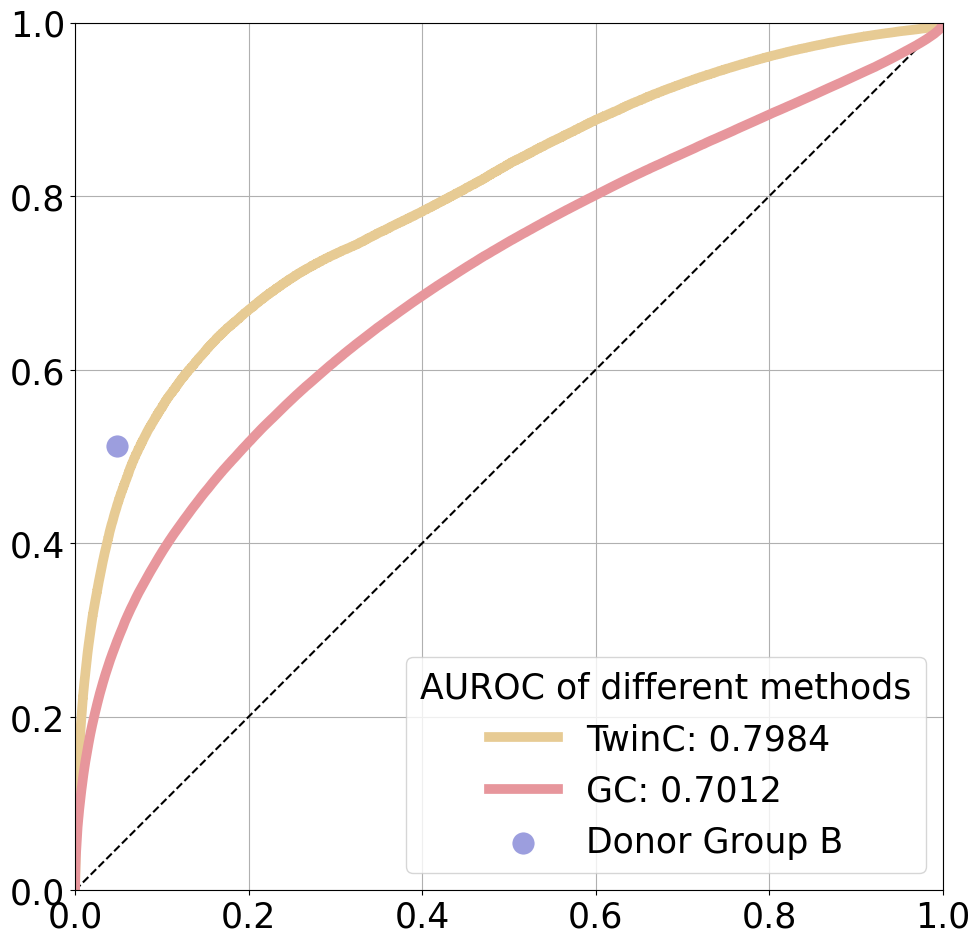

In [6]:
chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
all_true = []
all_pred = []
all_rep = []
all_pred_gc = []
for chrA, chrB in chr_combs: 
    binary_replicate = f"../../results/common_matrix_5_v_5_right/{chrA}_{chrB}_heart_right_ventricle_100000_5_v_5_replicate.gz"

    binary_replicate_contacts = pickle.load(gzip.open(binary_replicate, 'rb'))

    rep_labels = np.zeros((binary_replicate_contacts.hic_pos_num_sup.shape))
    rep_labels[:, :] = binary_replicate_contacts.hic_pos_num_sup
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==1] = 1
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==1] = 0

    hic_values_rep = binary_replicate_contacts.hic_sum
    test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_right//{chrA}_{chrB}_test_results.npz")

    hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
    hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
    hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

    true_matrix = np.zeros((hic_pos_num_sup.shape))
    true_matrix[:, :] = np.nan

    true_matrix[hic_pos_num_sup==1] = 1
    true_matrix[hic_neg_num_sup==1] = 0

    valid = np.isfinite(true_matrix) * np.isfinite(rep_labels)

    all_true.extend(true_matrix[valid].flatten())
    all_pred.extend(pred_matrix[valid].flatten())
    all_rep.extend(rep_labels[valid].flatten())
    all_pred_gc.extend(pred_matrix_gc[valid].flatten())

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]
figure, axis = plt.subplots(1, 1, figsize=(17, 10))
axis.plot([0, 1.0], [0, 1.0], "k--")

axis.grid(True)
fpr, tpr, thresholds = roc_curve(all_true, all_pred, pos_label=1)
twincnn_auroc = roc_auc_score(all_true, all_pred)
axis.plot(fpr, tpr, linewidth=7.0, label=f"TwinC: {twincnn_auroc:0.4f}", color=colors[1])

fpr, tpr, thresholds = roc_curve(all_true, all_pred_gc, pos_label=1)
gc_auroc = roc_auc_score(all_true, all_pred_gc)
axis.plot(fpr, tpr, linewidth=7.0, label=f"GC: {gc_auroc:0.4f}", color=colors[2])
    
fpr, tpr, thresholds = roc_curve(all_true, all_rep, pos_label=1)
donor_auroc = roc_auc_score(all_true, all_rep)
axis.scatter(fpr[1], tpr[1], linewidth=10.0, label=f"Donor Group B", color=colors[0])

axis.set_aspect('equal', adjustable='box')
axis.set_xlim([0, 1.0])
axis.set_ylim([0, 1.0])
plt.legend(title="AUROC of different methods", loc='lower right')
plt.tight_layout()
plt.savefig(f"../../figures/classification_accuracy/test_roc_hrv.pdf", transparent=True) 
plt.show()

## 3. Predictive accuracy by chromosome length

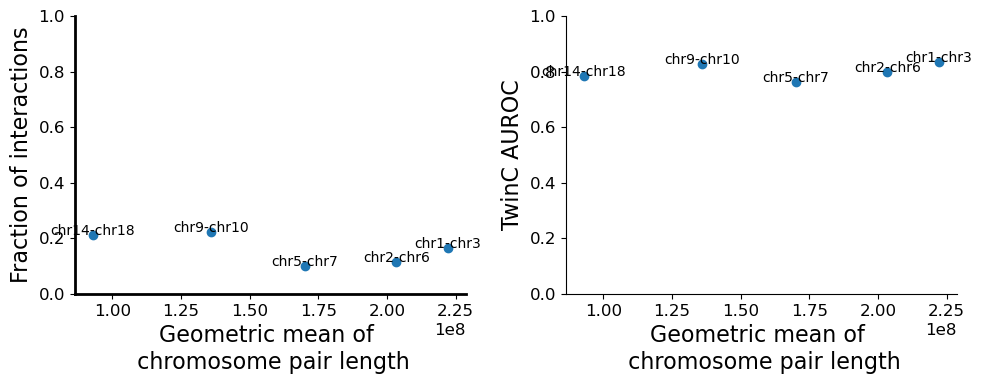

In [7]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]

chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
chr_comb_gmeans = [gmean([248956422, 198295559]), 
                    gmean([242193529, 170805979]), 
                    gmean([181538259, 159345973]), 
                    gmean([138394717, 133797422]), 
                    gmean([107043718, 80373285])]
all_auroc = []
all_chrpairs = []
pos_all = []
neg_all = []
for i in range(len(chr_combs)):
    chrA, chrB = chr_combs[i]
    #print(chrA, chrB)
    binary_replicate = f"../../results/common_matrix_5_v_5_right/{chrA}_{chrB}_heart_right_ventricle_100000_5_v_5_replicate.gz"

    binary_replicate_contacts = pickle.load(gzip.open(binary_replicate, 'rb'))

    rep_labels = np.zeros((binary_replicate_contacts.hic_pos_num_sup.shape))
    rep_labels[:, :] = binary_replicate_contacts.hic_pos_num_sup
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==0] = np.nan
    rep_labels[binary_replicate_contacts.hic_pos_num_sup==1] = 1
    rep_labels[binary_replicate_contacts.hic_neg_num_sup==1] = 0

    hic_values_rep = binary_replicate_contacts.hic_sum
    test_results_pos_pos = np.load(f"../../results/common_matrix_5_v_5_right//{chrA}_{chrB}_test_results.npz")

    hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
    hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
    hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

    true_matrix = np.zeros((hic_pos_num_sup.shape))
    true_matrix[:, :] = np.nan

    true_matrix[hic_pos_num_sup==1] = 1
    true_matrix[hic_neg_num_sup==1] = 0

    valid = np.isfinite(true_matrix) * np.isfinite(rep_labels)

    all_true = true_matrix[valid].flatten()
    all_pred = pred_matrix[valid].flatten()
    
    pos_all.append(np.sum(all_true==1)/float(len(all_true)))
    neg_all.append(np.sum(all_true==0)/float(len(all_true)))
    
    twincnn_auroc = roc_auc_score(all_true, all_pred)
    all_auroc.append(twincnn_auroc)
    all_chrpairs.append(f"{chrA}-{chrB}")

figure, axis = plt.subplots(1, 2, figsize=(10, 4))

for ax in ['top','bottom','left','right']:
    axis[0].spines[ax].set_linewidth(2)

    
axis[0].scatter(chr_comb_gmeans, pos_all)
for i in range(len(chr_comb_gmeans)):
    axis[0].text(chr_comb_gmeans[i], pos_all[i], f'{all_chrpairs[i]}', fontsize=10, ha='center')
axis[0].set_ylim([0, 1])
axis[0].set_xlabel("Geometric mean of \n chromosome pair length")
axis[0].set_ylabel("Fraction of interactions")
axis[0].spines[['right', 'top']].set_visible(False)

axis[1].scatter(chr_comb_gmeans, all_auroc)
for i in range(len(chr_comb_gmeans)):
    axis[1].text(chr_comb_gmeans[i], all_auroc[i], f'{all_chrpairs[i]}', fontsize=10, ha='center')
axis[1].set_ylim([0, 1])
axis[1].set_xlabel("Geometric mean of \n chromosome pair length")
axis[1].set_ylabel("TwinC AUROC")
axis[1].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig("../../figures/classification_accuracy/hrv_per_chrom_accuracy.pdf", transparent=True)
plt.show()